# Restaurant Recommendation System

## Introduction
Recommedation Systems are ubiquitous. They help you decide where to eat (zomato), what to buy (amazon), whom to marry(matrimony), what to listen(spotify). In this project we'll build a Restaurant Recommendation System using Collaborative Filtering from scratch. We have been given [Yelp Dataset](https://www.yelp.com/dataset) which has information of various users and their reviews to various businesses. Our model would learn from this information and would recommend new options to our users.

## Motivation
Due to the sheer amount of information available on the internet users feel overwhelmed with number of options available. To deal with this problem websites have Recommendation Systems, which simplifies decision making on user's part by showing options user might like based on his purchase history. Recommedation Systems play a very important role in websites like Youtube, Amazon, Spotify most of their revenue is driven by it.

## Team

This is final project for ML1. Team members include:

- Iniyan Nagaraju
- Jameel Khan
- Yashraj Wani
- Aziza 
- Akshay Kumar
- Gunakar Goswami

## Project Structure
This project is divided in three jupyter notebooks.
1. Getting Data Ready
2. Exploratory Data Analysis (EDA)
3. Modelling

## 1. Getting Data Ready
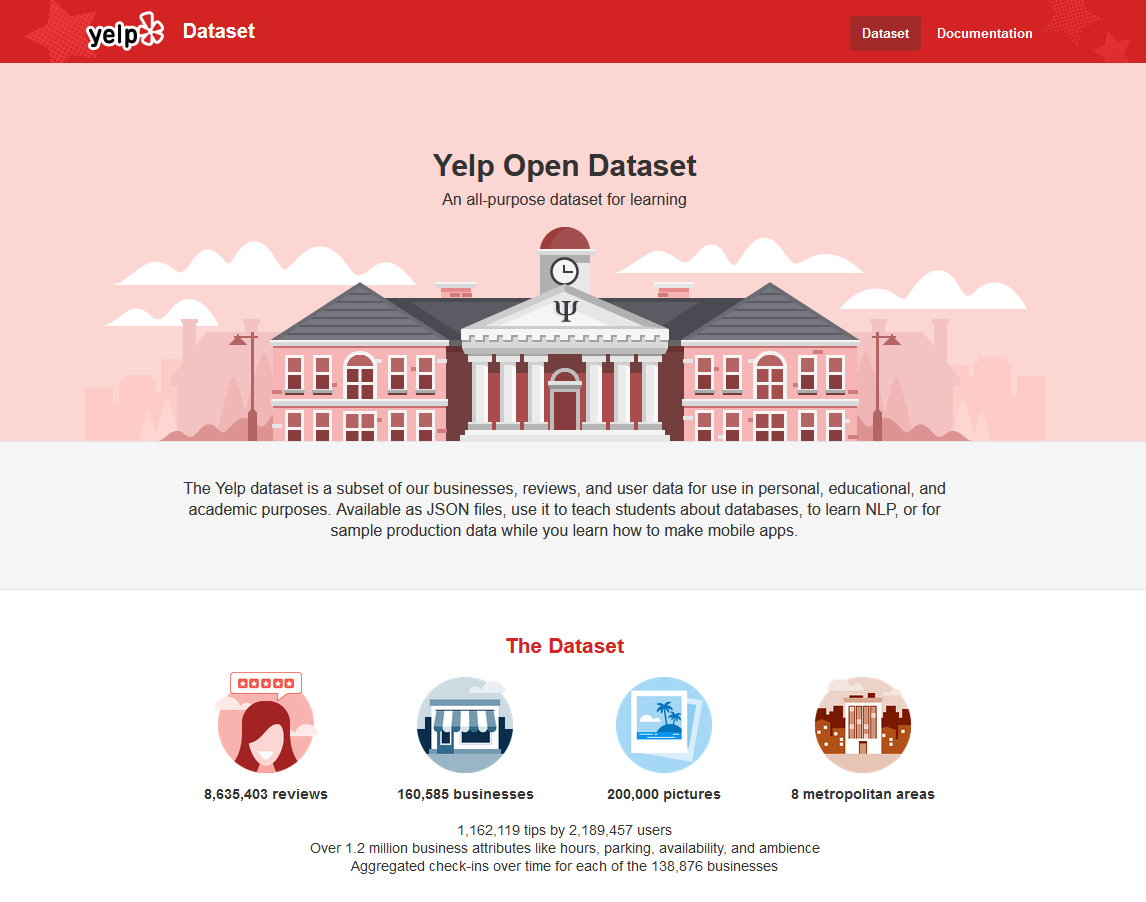

## Aim
We have been given [Yelp Dataset](https://www.yelp.com/dataset). In this notebook we'll go through data given to us, clean it and, save it so that we can use it for further steps. 

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json
from sqlite3 import dbapi2 as sq3
from pathlib import Path
from collections import OrderedDict

# import tensorflow as tf
# from tensorflow import keras

from time import time
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

### Loading Data

In [2]:
#Dataset Doc: https://www.yelp.com/dataset/documentation/main
#Data Paths
REVIEW_PATH = '/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json'      #Contains full review text data including the user_id that wrote the review and the business_id the review is written for.
CHECKIN_PATH = '/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json'    #Checkins on a business.
BUSINESS_PATH = '/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json'  #Contains business data including location data, attributes, and categories.
TIP_PATH = '/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json'            #Tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions.
USER_PATH = '/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json'          #User data including the user's friend mapping and all the metadata associated with the user.

# Functions to load data from json format
#ref: https://www.kaggle.com/hexianwang/yelp-data
def load_rows(file_path, nrows=None, only_return_count=False, verbose=True):
    """
    Returns dataframe from json file
    """
    tic = time()
    with open(file_path) as json_file:
        count = 0
        objs = []
        line = json_file.readline()
        while (nrows is None or count<nrows) and line:
            count += 1
            if not only_return_count:
                obj = json.loads(line)
                objs.append(obj)
            line = json_file.readline()
        toc = time()
        if verbose:
            print(file_path.split('/')[-1], 'loaded. Count =', count, ', Time =', round(toc-tic,2), 'secs.')
        
        if only_return_count:
            return count
        
        return pd.DataFrame(objs)
    
    
#data generator to load data in chunks
def load_rows_gen(file_path, nrows=1e6, verbose=True):
    """
    Returns data in chunks
    """
    with open(file_path) as json_file:
        line = json_file.readline()
        total = 0
        while line:
            count = 0
            objs = []
            tic = time()
            while count<nrows and line:
                count+=1
                obj = json.loads(line)
                objs.append(obj)
                line = json_file.readline()
                total += count
            toc = time()
            print('Loaded chunk of size:', count, ", Time =", round(toc-tic,2), 'secs.')
            yield pd.DataFrame(objs)

### Looking at data

In [3]:
user_df_head = load_rows(USER_PATH, 5)
user_df_head

yelp_academic_dataset_user.json loaded. Count = 5 , Time = 0.01 secs.


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,ntlvfPzc8eglqvk92iDIAw,Rafael,553,2007-07-06 03:27:11,628,225,227,,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg...",14,...,2,1,0,1,11,15,22,22,10,0
1,FOBRPlBHa3WPHFB5qYDlVg,Michelle,564,2008-04-28 01:29:25,790,316,400,"2008,2009,2010,2011,2012,2013","ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug...",27,...,4,5,2,1,33,37,63,63,21,5
2,zZUnPeh2hEp0WydbAZEOOg,Martin,60,2008-08-28 23:40:05,151,125,103,2010,"Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnPQ...",5,...,6,0,1,0,3,7,17,17,4,1
3,QaELAmRcDc5TfJEylaaP8g,John,206,2008-09-20 00:08:14,233,160,84,2009,"iog3Nyg1i4jeumiTVG_BSA, M92xWY2Vr9w0xoH8bPplfQ...",6,...,1,0,0,0,7,14,7,7,2,0
4,xvu8G900tezTzbbfqmTKvA,Anne,485,2008-08-09 00:30:27,1265,400,512,"2009,2010,2011,2012,2014,2015,2016,2017,2018","3W3ZMSthojCUirKEqAwGNw, eTIbuu23j9tOgmIa9POyLQ...",78,...,9,2,1,1,22,28,31,31,19,31


In [4]:
review_df_head = load_rows(REVIEW_PATH, 5)
review_df_head

yelp_academic_dataset_review.json loaded. Count = 5 , Time = 0.01 secs.


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57


In [5]:
business_df_head = load_rows(BUSINESS_PATH, 5)
business_df_head.head()

yelp_academic_dataset_business.json loaded. Count = 5 , Time = 0.01 secs.


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,None,"Pets, Pet Services, Pet Groomers",None
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Hardware Stores, Home Services, Building Suppl...","{'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '..."


In [6]:
checkin_df_head = load_rows(CHECKIN_PATH, 5)
checkin_df_head

yelp_academic_dataset_checkin.json loaded. Count = 5 , Time = 0.01 secs.


,business_id,date
0,--1UhMGODdWsrMastO9DZw,"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016..."
1,--6MefnULPED_I942VcFNA,"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012..."
2,--7zmmkVg-IMGaXbuVd0SQ,"2014-12-29 19:25:50, 2015-01-17 01:49:14, 2015..."
3,--8LPVSo5i0Oo61X01sV9A,2016-07-08 16:43:30
4,--9QQLMTbFzLJ_oT-ON3Xw,"2010-06-26 17:39:07, 2010-08-01 20:06:21, 2010..."


In [7]:
tip_df_head = load_rows(TIP_PATH, 5)
tip_df_head

yelp_academic_dataset_tip.json loaded. Count = 5 , Time = 0.01 secs.


,user_id,business_id,text,date,compliment_count
0,hf27xTME3EiCp6NL6VtWZQ,UYX5zL_Xj9WEc_Wp-FrqHw,Here for a quick mtg,2013-11-26 18:20:08,0
1,uEvusDwoSymbJJ0auR3muQ,Ch3HkwQYv1YKw_FO06vBWA,Cucumber strawberry refresher,2014-06-15 22:26:45,0
2,AY-laIws3S7YXNl_f_D6rQ,rDoT-MgxGRiYqCmi0bG10g,Very nice good service good food,2016-07-18 22:03:42,0
3,Ue_7yUlkEbX4AhnYdUfL7g,OHXnDV01gLokiX1ELaQufA,It's a small place. The staff is friendly.,2014-06-06 01:10:34,0
4,LltbT_fUMqZ-ZJP-vJ84IQ,GMrwDXRlAZU2zj5nH6l4vQ,"8 sandwiches, $24 total...what a bargain!!! An...",2011-04-08 18:12:01,0


We'll be using User (details abouts user), Business (Details about business), and Review (users and their reviews for business) data.

### Create SQLite database
As data size is more than what our RAM can handle.

In [8]:
# Functions to work with db2api from sqlite3

PATHSTART = "."
def get_db(dbfile):
    #get connection to db
    sqlite_db = sq3.connect(Path(PATHSTART)/ dbfile)
    return sqlite_db

def init_db(dbfile, schema):
    #create db a/c to schema
    db = get_db(dbfile)
    
    #execute sql code
    c = db.cursor()
    c.executescript(schema)
    
    #make commit
    db.commit()
    return db

def make_query(sel):
    c = db.cursor().execute(sel)
    return c.fetchall()

from collections import OrderedDict
def make_frame(list_of_tuples, legend):
    framelist=[]
    for i, cname in enumerate(legend):
        framelist.append((cname,[e[i] for e in list_of_tuples]))
    return pd.DataFrame.from_dict(OrderedDict(framelist)) 

In [9]:
#Table Schema for tables in our SQLite database

users_schema = """
DROP TABLE IF EXISTS "users";

CREATE TABLE "users" (
    "user_id" INTEGER PRIMARY KEY NOT NULL,
    "name" VARCHAR,
    "review_count" INTEGER,
    "yelping_since" TIMESTAMP,
    "useful" INTEGER,
    "funny" INTEGER,
    "cool" INTEGER,
    "elite" VARCHAR,
    "friends" VARCHAR,
    "fans" INTEGER,
    "average_stars" FLOAT,
    "compliment_hot" INTEGER,
    "compliment_more" INTEGER, 
    "compliment_profile" INTEGER,
    "compliment_cute" INTEGER,
    "compliment_list" INTEGER,
    "compliment_note" INTEGER,
    "compliment_plain" INTEGER,
    "compliment_cool" INTEGER,
    "compliment_funny" INTEGER,
    "compliment_writer" INTEGER,
    "compliment_photos" INTEGER
);
"""
businesses_schema="""
DROP TABLE IF EXISTS "businesses";

CREATE TABLE "businesses" (
    "business_id" INTEGER PRIMARY KEY NOT NULL,
    "name" VARCHAR,
    "address" VARCHAR,
    "city" VARCHAR,
    "state" VARCHAR,
    "postal_code" VARCHAR,
    "latitude" FLOAT,
    "longitude" FLOAT,
    "stars" FLOAT,
    "review_count" INTEGER,
    "is_open" BOOLEAN,
    "categories" VARCHAR,
"""
reviews_schema = """
DROP TABLE IF EXISTS "reviews";

CREATE TABLE "reviews" (
    "review_id" VARCHAR PRIMARY KEY,
    "user_id" INTEGER,
    "business_id" INTEGER,
    "stars" FLOAT,
    "useful" INTEGER,
    "funny" INTEGER,
    "cool" INTEGER,
    "text"  VARCHAR,
    "date" TIMESTAMP,
    
    
    FOREIGN KEY (user_id) REFERENCES users(user_id),
    FOREIGN KEY (business_id) REFERENCES businesses(business_id)
);
"""
schema_close = ");"

In [10]:
#Load data about all businesses
business_df = load_rows(BUSINESS_PATH)
business_df.head()

yelp_academic_dataset_business.json loaded. Count = 209393 , Time = 5.32 secs.


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,None,"Pets, Pet Services, Pet Groomers",None
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Hardware Stores, Home Services, Building Suppl...","{'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '..."


In [11]:
%%time

#Here we preprocess our businesses data
def preprocess_business_df(df):
    """
    Preprocess data from BUSINESS_PATH
    returns final DataFrame
    """
    #mask to only select businesses which are either Restaurant or serve Food
    mask = df.categories.str.contains('Restaurant', na=False) | df.categories.str.contains('Food', na=False)
    df = df[mask]
    #Changing business_id to numbers
    global businessid_to_idx
    businessid_to_idx = {b_id : idx for idx, b_id in enumerate(df.business_id.unique())}
    df.business_id = df.business_id.map(lambda x: businessid_to_idx[x])

    #TDT
    df.is_open = df.is_open.astype(bool)

    # Exploding attributes [MultiCategorization]
    attr = [col for col in df.attributes.explode().unique() if col is not None]
    lst_of_attr_dict = []
    for attr_dict in df.attributes:
        if not attr_dict:
            lst_of_attr_dict.append({})
            continue

        if 'BusinessParking' in attr_dict:
            if type(attr_dict['BusinessParking']) == str:
                attr_dict['BusinessParking'] = ('True' in attr_dict['BusinessParking'])

        lst_of_attr_dict.append(attr_dict)
    
    attr_df = pd.DataFrame(lst_of_attr_dict, columns=attr)
    for col in attr_df:
        #Handling missing
        #Strategy -> absence of attribute means restauratn doesn't have it
        #ex. If parking is null then restaurant doesn't have parking
        attr_df[col] = attr_df[col].fillna(False).astype(bool)
    
    df = pd.concat([df.reset_index().drop('index', axis=1), attr_df], axis=1)
    df.drop(['attributes'], axis=1, inplace=True)
    
    #Exploding hours ie. getting opening and closing time for various days
    lst_of_time = []
    for time_dict in df.hours:
        if not time_dict:
            lst_of_time.append({})
            continue
        lst_of_time.append(time_dict)
    time_df = pd.DataFrame(lst_of_time)
    df = pd.concat([df, time_df], axis=1).drop('hours', axis=1)
    
    return df

business_df = preprocess_business_df(business_df)
business_df.head()

CPU times: user 3.86 s, sys: 45.4 ms, total: 3.91 s
Wall time: 3.91 s


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,RestaurantsCounterService,Open24Hours,HairSpecializesIn,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0,The Empanadas House,404 E Green St,Champaign,IL,61820,40.110446,-88.233073,4.5,5,...,False,False,False,11:30-14:30,11:30-14:30,11:30-14:30,11:30-14:30,11:30-14:30,NaN,NaN
1,1,Chocolate Shoppe Ice Cream,2831 Parmenter St,Middleton,WI,53562,43.105310,-89.510142,3.5,6,...,False,False,False,0:0-0:0,11:0-21:0,11:0-21:0,11:0-21:0,11:0-22:0,11:0-22:0,11:0-21:0
2,2,Middle East Deli,4508 E Independence Blvd,Charlotte,NC,28205,35.194894,-80.767442,3.0,5,...,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Tipsy Ryde,,Gastonia,NC,28054,35.252842,-81.152698,3.5,3,...,False,False,False,0:0-0:0,9:0-0:0,9:0-0:0,9:0-0:0,9:0-2:30,9:0-2:30,12:0-0:0
4,4,Philthy Phillys,"15480 Bayview Avenue, unit D0110",Aurora,ON,L4G 7J1,44.010962,-79.448677,4.5,4,...,False,False,False,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,11:0-21:0


In [12]:
# Looking at overview of our data
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80505 entries, 0 to 80504
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 80505 non-null  int64  
 1   name                        80505 non-null  object 
 2   address                     80505 non-null  object 
 3   city                        80505 non-null  object 
 4   state                       80505 non-null  object 
 5   postal_code                 80505 non-null  object 
 6   latitude                    80505 non-null  float64
 7   longitude                   80505 non-null  float64
 8   stars                       80505 non-null  float64
 9   review_count                80505 non-null  int64  
 10  is_open                     80505 non-null  bool   
 11  categories                  80505 non-null  object 
 12  RestaurantsAttire           80505 non-null  bool   
 13  RestaurantsTakeOut          805

In [13]:
# Completing Business Table Schema
for bool_col in business_df.columns[12:51]:
    businesses_schema += '    \"' + bool_col + '\"' + ' BOOLEAN,\n'
for day in business_df.columns[51:]:
    businesses_schema += '    \"' + day + '\"' + ' VARCHAR,\n'
    
businesses_schema = businesses_schema[:-2] + schema_close

In [14]:
%%time
#Create db
db = init_db("yelp_database.db", users_schema+businesses_schema+reviews_schema)

#business data to sql
business_df.to_sql('businesses', db, if_exists='append', index=False)

#release memory
del business_df

CPU times: user 5.56 s, sys: 50.8 ms, total: 5.61 s
Wall time: 5.71 s


In [15]:
#load data about users
user_df = load_rows(USER_PATH)
user_df.head()

yelp_academic_dataset_user.json loaded. Count = 1968703 , Time = 68.2 secs.


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,ntlvfPzc8eglqvk92iDIAw,Rafael,553,2007-07-06 03:27:11,628,225,227,,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg...",14,...,2,1,0,1,11,15,22,22,10,0
1,FOBRPlBHa3WPHFB5qYDlVg,Michelle,564,2008-04-28 01:29:25,790,316,400,"2008,2009,2010,2011,2012,2013","ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug...",27,...,4,5,2,1,33,37,63,63,21,5
2,zZUnPeh2hEp0WydbAZEOOg,Martin,60,2008-08-28 23:40:05,151,125,103,2010,"Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnPQ...",5,...,6,0,1,0,3,7,17,17,4,1
3,QaELAmRcDc5TfJEylaaP8g,John,206,2008-09-20 00:08:14,233,160,84,2009,"iog3Nyg1i4jeumiTVG_BSA, M92xWY2Vr9w0xoH8bPplfQ...",6,...,1,0,0,0,7,14,7,7,2,0
4,xvu8G900tezTzbbfqmTKvA,Anne,485,2008-08-09 00:30:27,1265,400,512,"2009,2010,2011,2012,2014,2015,2016,2017,2018","3W3ZMSthojCUirKEqAwGNw, eTIbuu23j9tOgmIa9POyLQ...",78,...,9,2,1,1,22,28,31,31,19,31


In [16]:
%%time
#Preproccess user data
def preprocess_user_df(df):
    #Changing user id to something more suitable for our analysis
    global userid_to_idx
    userid_to_idx = {user : idx for idx, user in enumerate(df.user_id.unique())}
    df.user_id = df.user_id.map(lambda x: userid_to_idx[x])
    #Changing friends ids to new int ids
    df.friends = df.friends.map(lambda x : str([userid_to_idx[user] for user in x.split(',') if user in userid_to_idx]))
    #TDT to datetime
    df.yelping_since = pd.to_datetime(df.yelping_since)
    df.elite = df.elite.replace('', np.nan)
    return df

user_df = preprocess_user_df(user_df)

CPU times: user 41.4 s, sys: 133 ms, total: 41.5 s
Wall time: 41.5 s


In [17]:
%%time
#Sending user data to SQL db
user_df.to_sql('users', db, if_exists='append', index=False)
#Release memory
del user_df

CPU times: user 20.6 s, sys: 961 ms, total: 21.6 s
Wall time: 22.1 s


In [18]:
%%time
#Here we load data from reviews

#size of review.json overpowers RAM hence we'll process data in chunks and store it to table
for data in load_rows_gen(REVIEW_PATH):
    #transformations
    data.user_id = data.user_id.apply(lambda key : userid_to_idx[key] if key in userid_to_idx else np.nan)
    data.business_id = data.business_id.apply(lambda key : businessid_to_idx[key] if key in businessid_to_idx else np.nan)
    data.date = pd.to_datetime(data.date)
    data.dropna(inplace=True)
    #sending chunk to sql
    data.to_sql('reviews', db, if_exists='append', index=False)
#del data

Loaded chunk of size: 1000000 , Time = 16.73 secs.
Loaded chunk of size: 1000000 , Time = 16.66 secs.
Loaded chunk of size: 1000000 , Time = 16.68 secs.
Loaded chunk of size: 1000000 , Time = 16.37 secs.
Loaded chunk of size: 1000000 , Time = 15.92 secs.
Loaded chunk of size: 1000000 , Time = 16.19 secs.
Loaded chunk of size: 1000000 , Time = 16.53 secs.
Loaded chunk of size: 1000000 , Time = 17.43 secs.
Loaded chunk of size: 21122 , Time = 0.44 secs.
CPU times: user 4min 11s, sys: 54.2 s, total: 5min 5s
Wall time: 6min 13s


In [19]:
#Looking at last chunk
data.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
3,Jm4YrhKNaOQosu_sxYpzSQ,1862462,78762.0,5.0,0,0,0,I love this place. Everything is so fresh and ...,2019-03-26 19:47:36
4,lBCKTKJR3eM1dizqKjRThA,919988,74067.0,3.0,0,0,0,Very average pho joint. Nothing particularly s...,2019-04-06 00:52:48
6,CgMgg0WuqEEF4gIHN15iwQ,405170,78109.0,4.0,0,0,0,Went here as we don't have Waffle House's in C...,2019-03-25 02:42:04
7,OqcPyHuVAvOCWVw-NHJC-Q,236706,77449.0,2.0,2,1,0,VERY unhappy w/ my experience here. I ordered ...,2016-08-06 21:17:45
8,h9aEvF_mgZ7KzTghG_Um3Q,1909738,75904.0,4.0,0,0,1,What a place. A restaurant with decor and char...,2012-12-06 20:38:34


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12152 entries, 3 to 21121
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   review_id    12152 non-null  object        
 1   user_id      12152 non-null  int64         
 2   business_id  12152 non-null  float64       
 3   stars        12152 non-null  float64       
 4   useful       12152 non-null  int64         
 5   funny        12152 non-null  int64         
 6   cool         12152 non-null  int64         
 7   text         12152 non-null  object        
 8   date         12152 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 949.4+ KB


In [21]:
#Release memory
del data

## Conclusion
- We made a SQLite db from our data.
- Our db has 3 tables:
 - reviews (has review info)
 - users (has user info)
 - businesses (has business info)
- Made basic transformations like simple null handling, changing id, type casting.

#### Links

[2. Exploratory Data Analysis (EDA)](https://github.com/yashrajwani/Restaurant-Recommendation-System/blob/main/2.%20Exploratory%20Data%20Analysis%20(EDA).ipynb)

[3. Modelling](https://github.com/yashrajwani/Restaurant-Recommendation-System/blob/main/3.%20Modelling%20(Recommendation%20System).ipynb)